<a href="https://colab.research.google.com/github/sj442/Binary-prediction-of-rainfall/blob/master/S5e3_Rainfall_prediction_Keras_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
from google.colab import files
files.upload()

In [ ]:
! pip install -q kaggle

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

!pip install sweetviz ydata-profiling dtale

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [5]:
# Synthetic dataset for competition
! kaggle competitions download -c playground-series-s5e3

# Original dataset
! kaggle datasets download subho117/rainfall-prediction-using-machine-learning

Dataset URL: https://www.kaggle.com/datasets/subho117/rainfall-prediction-using-machine-learning
License(s): MIT


# Data

In [6]:
import zipfile

with zipfile.ZipFile('playground-series-s5e3.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/kaggle/')

with zipfile.ZipFile('rainfall-prediction-using-machine-learning.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/kaggle/')

In [7]:
train = pd.read_csv('/content/kaggle/train.csv')
test = pd.read_csv('/content/kaggle/test.csv')
sub = pd.read_csv('/content/kaggle/sample_submission.csv')
orig = pd.read_csv('/content/kaggle/Rainfall.csv')

In [8]:
orig.columns = ['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'rainfall', 'sunshine', 'winddirection',  'windspeed']

# High level stats

In [ ]:
# Display basic info
print(train.info())  # Data types and missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2190 non-null   int64  
 1   day            2190 non-null   int64  
 2   pressure       2190 non-null   float64
 3   maxtemp        2190 non-null   float64
 4   temparature    2190 non-null   float64
 5   mintemp        2190 non-null   float64
 6   dewpoint       2190 non-null   float64
 7   humidity       2190 non-null   float64
 8   cloud          2190 non-null   float64
 9   sunshine       2190 non-null   float64
 10  winddirection  2190 non-null   float64
 11  windspeed      2190 non-null   float64
 12  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(3)
memory usage: 222.6 KB
None


In [ ]:
train.describe()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
count,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000
mean,1094.500000,179.948402,1013.602146,26.365799,23.953059,22.170091,20.454566,82.036530,75.721918,3.744429,104.863151,21.804703,0.753425
std,632.342866,105.203592,5.655366,5.654330,5.222410,5.059120,5.288406,7.800654,18.026498,3.626327,80.002416,9.898659,0.431116
min,0.000000,1.000000,999.000000,10.400000,7.400000,4.000000,-0.300000,39.000000,2.000000,0.000000,10.000000,4.400000,0.000000
25%,547.250000,89.000000,1008.600000,21.300000,19.300000,17.700000,16.800000,77.000000,69.000000,0.400000,40.000000,14.125000,1.000000
50%,1094.500000,178.500000,1013.000000,27.800000,25.500000,23.850000,22.150000,82.000000,83.000000,2.400000,70.000000,20.500000,1.000000
75%,1641.750000,270.000000,1017.775000,31.200000,28.400000,26.400000,25.000000,88.000000,88.000000,6.800000,200.000000,27.900000,1.000000
max,2189.000000,365.000000,1034.600000,36.000000,31.500000,29.800000,26.700000,98.000000,100.000000,12.100000,300.000000,59.500000,1.000000


In [ ]:
train.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


In [ ]:
from ydata_profiling import ProfileReport

# Generate and display report
profile = ProfileReport(train, explorative=True)
profile.to_notebook_iframe()

In [ ]:
import sweetviz as sv

# Generate and display report
report = sv.analyze(train)
report.show_html("sweetviz_report.html")

## Comparing train, test and original datasets

In [ ]:
# Generate comparison report
report = sv.compare([train, "Train Data"], [test, "Test Data"])

# Show the report
report.show_html("train_vs_test.html")  # Opens in browser

In [ ]:
# Generate comparison report
report = sv.compare([train, "Train Data"], [orig, "Original Data"])

# Show the report
report.show_html("train_vs_orig.html")  # Opens in browser

# Cleaning & Imputing missing values

In [9]:
# Changing the original dataset rainfall column training data

# 75% : 25% ratio of 1:0 in training data
# 68% : 32% ratio of 1:0 in original data
mapping_dict = {'yes': 1, 'no': 0}
orig['rainfall'] = orig['rainfall'].map(mapping_dict)


# 1 missing value in the windspeed and winddirection column in original dataset
orig['windspeed'] = orig['windspeed'].fillna(orig.windspeed.mean())
orig['winddirection'] = orig['winddirection'].fillna(orig.winddirection.mean())

# 1 missing value in the winddirection column in test dataset
test['winddirection']= test['winddirection'].fillna(test.winddirection.mean())

Target = 'rainfall'
Features = train.columns.drop([Target, 'id'])

# Neural Networks

In [10]:
X = train.drop(['rainfall'], axis=1)
y = train['rainfall']
X_train = train.drop(columns=['day', 'rainfall'])
y_train = train['rainfall']
X_test = test.drop(columns=['day'])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [13]:
model = Sequential([
    Dense(128, activation='relu', kernel_initializer='he_normal', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_initializer='he_normal', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.2),
    Dense(16, activation='relu', kernel_initializer='he_normal'),
    Dense(1, activation='sigmoid')  # Binary classification
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
history = model.fit(X_train_scaled, y_train, epochs=200, batch_size=32, validation_split=0.2,
                    callbacks=[early_stopping], verbose=1)

Epoch 1/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5909 - loss: 0.7168 - val_accuracy: 0.8493 - val_loss: 0.3597
Epoch 2/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7788 - loss: 0.4561 - val_accuracy: 0.8653 - val_loss: 0.3576
Epoch 3/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8120 - loss: 0.4382 - val_accuracy: 0.8790 - val_loss: 0.3439
Epoch 4/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8440 - loss: 0.4016 - val_accuracy: 0.8767 - val_loss: 0.3450
Epoch 5/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8553 - loss: 0.3727 - val_accuracy: 0.8744 - val_loss: 0.3437
Epoch 6/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8564 - loss: 0.3842 - val_accuracy: 0.8744 - val_loss: 0.3357
Epoch 7/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8526 - loss: 0.3681 - val_accuracy: 0.8721 - val_loss: 0.3328
Epoch 8/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8488 - loss: 0.3759 - val_accuracy: 0.8676 - v

In [17]:
y_pred_keras = model.predict(X_test_scaled).flatten()

# Save Submission
sub['rainfall'] = y_pred_keras
sub.to_csv('subm_keras.csv', index=False)
sub.head()

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,id,rainfall
0,2190,0.991068
1,2191,0.994594
2,2192,0.966208
3,2193,0.235954
4,2194,0.104130


## Checking the effect of Kernel initializer

The default kernel initializer (Glorot uniform) performs better than he_normal which is supposed to perform better with ReLU activation

In [21]:
model_def = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

optimizer = Adam(learning_rate=0.001)
model_def.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

history = model_def.fit(X_train_scaled, y_train, epochs=200, batch_size=32, validation_split=0.2,
                    callbacks=[early_stopping], verbose=1)

Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7689 - loss: 0.5399 - val_accuracy: 0.8676 - val_loss: 0.3375
Epoch 2/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8600 - loss: 0.3509 - val_accuracy: 0.8767 - val_loss: 0.3327
Epoch 3/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8601 - loss: 0.3630 - val_accuracy: 0.8744 - val_loss: 0.3288
Epoch 4/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8503 - loss: 0.3749 - val_accuracy: 0.8653 - val_loss: 0.3318
Epoch 5/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8627 - loss: 0.3476 - val_accuracy: 0.8699 - val_loss: 0.3248
Epoch 6/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8501 - loss: 0.3587 - val_accuracy: 0.8699 - val_loss: 0.3263
Epoch 7/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8738 - loss: 0.3456 - val_accuracy: 0.8699 - val_loss: 0.3299
Epoch 8/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8752 - loss: 0.3321 - val_accuracy: 0.8699 - val_loss: 0.3

In [22]:
y_pred_keras = model_def.predict(X_test_scaled).flatten()

# Save Submission
sub['rainfall'] = y_pred_keras
sub.to_csv('subm_keras_v1.csv', index=False)
sub.head()

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


,id,rainfall
0,2190,0.993795
1,2191,0.996701
2,2192,0.979351
3,2193,0.150422
4,2194,0.042061


In [23]:
for layer in model_def.layers:
    print(layer.name, type(layer))
    print(layer.get_config())

dense_10 <class 'keras.src.layers.core.dense.Dense'>
{'name': 'dense_10', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'units': 128, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
dropout_6 <class 'keras.src.layers.regularization.dropout.Dropout'>
{'name': 'dropout_6', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'rate': 0.3, 'seed': None, 'noise_shape': None}
dense_11 <class 'keras.src.layers.core.dense.Dense'>
{'name': 'dense_11', 'trainable': True, 'dtype': {'mo

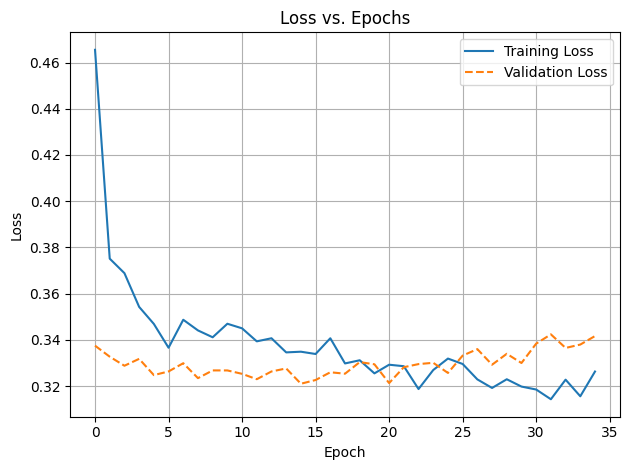

In [24]:
# Plotting loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()